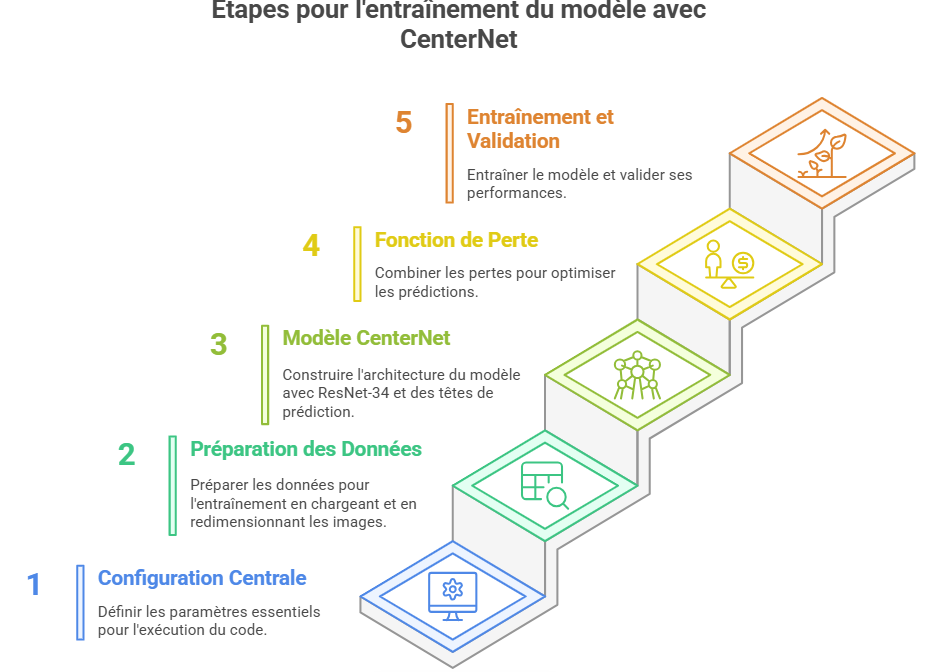

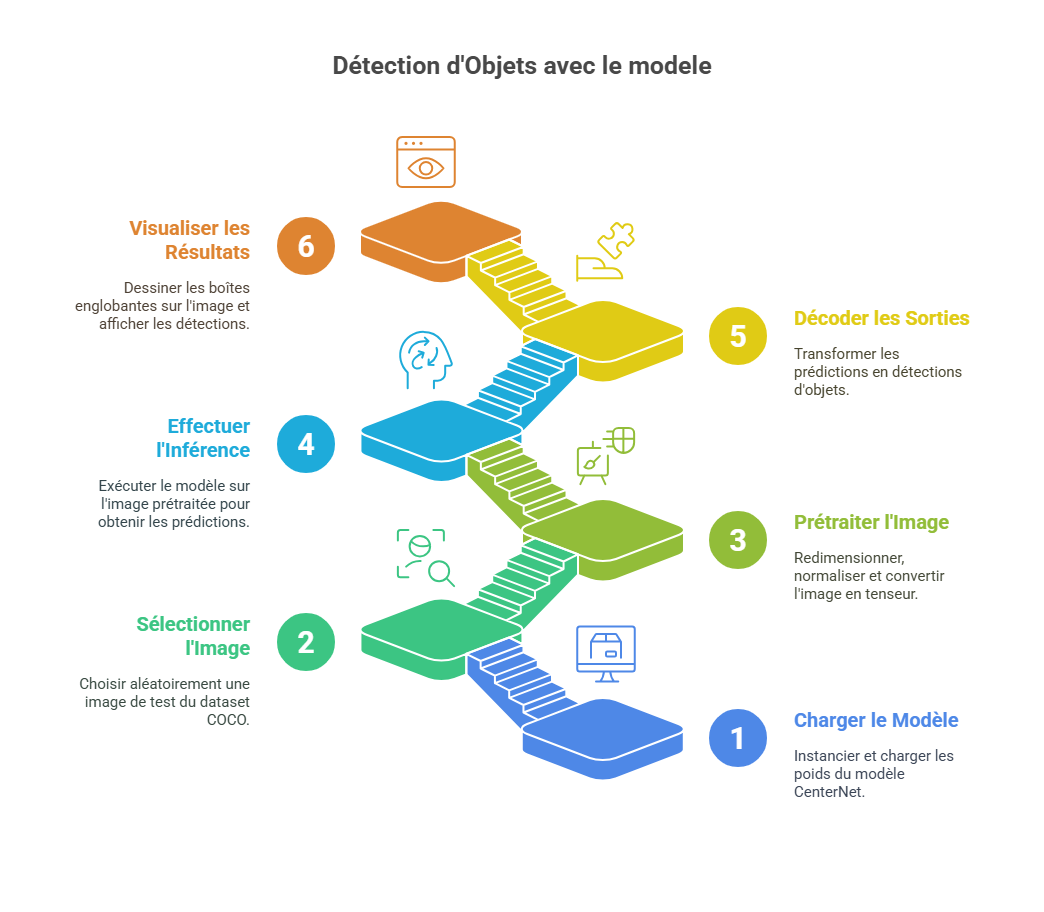

### Cette cellule initialise l'environnement pour traiter le dataset COCO 2017 dans le contexte d'un modèle CenterNet de détection d'objets.
Installation des dépendances :

##### pycocotools : API officielle pour manipuler les annotations COCO (format JSON complexe avec métadonnées d'images, bounding boxes, masques de segmentation)
##### L'option -q supprime les logs d'installation pour un affichage plus propre

## *Imports organisés par catégorie* :

#### Système : os pour la gestion des chemins de fichiers
#### Vision : cv2 (OpenCV) pour le traitement d'images, matplotlib.pyplot pour la visualisation
#### Data : json pour parser les fichiers d'annotations, numpy pour les opérations matricielles
#### Deep Learning : torch + Dataset/DataLoader pour créer des pipelines de données PyTorch optimisés
#### COCO : COCO classe principale pour charger et interroger les annotations

In [25]:
# Titre: Préparation du Dataset COCO 2017 pour CenterNet

# 1. Installation de la bibliothèque nécessaire pour les annotations COCO
!pip install pycocotools -q

# 2. Imports des bibliothèques standards
import os
import cv2
import json
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

print("Installation et imports terminés.")


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Installation et imports terminés.




### Structure des chemins COCO
- Organisation typique du dataset COCO 2017 avec séparation **train/val**
- Chemins codés en dur pour l'environnement Kaggle (`/kaggle/input/`)
- Les lignes commentées montrent une approche plus modulaire avec `BASE_PATH` (probablement pour tests locaux)

### Paramètres d'architecture CenterNet
- **Résolution d'entrée** : `512x512` pixels (compromis entre précision et vitesse de calcul)
- **Classes** : 80 catégories COCO standard (person, bicycle, car, etc.)
- **Down-sampling** : Facteur 4 → sortie de `128x128` pixels
  - Réduction classique via convolutions stride=2 dans le backbone (ResNet/DLA)
  - Permet de réduire la complexité computationnelle tout en conservant la précision

### Contraintes de mémoire
- `MAX_OBJECTS = 100` : Limite le nombre d'objets traités par image
  - Évite les problèmes de mémoire sur les images très denses
  - COCO peut avoir jusqu'à plusieurs centaines d'objets par image

### Implications techniques
- La sortie `128x128` contiendra les heatmaps de centres d'objets
- Chaque pixel de sortie correspond à une région `4x4` de l'image originale
- Cette configuration est standard pour CenterNet et offre un bon équilibre performance/précision

In [26]:
# --- Configuration Centrale ---

# Chemin vers le dataset COCO 2017 sur Kaggle
BASE_PATH = "/kaggle/input/2017-2017"
TRAIN_IMG_DIR = os.path.join("/kaggle/input/2017-2017/train2017/train2017")
# TRAIN_IMG_DIR = os.path.join(BASE_PATH, "/train2017/train2017")
TRAIN_ANN_FILE = os.path.join("/kaggle/input/2017-2017/annotations_trainval2017/annotations/instances_train2017.json")
# TRAIN_ANN_FILE = os.path.join(BASE_PATH, "/annotations_trainval2017/annotations/instances_train2017.json")
VAL_IMG_DIR = os.path.join("/kaggle/input/2017-2017/val2017/val2017")
# VAL_IMG_DIR = os.path.join(BASE_PATH, "/val2017/val2017")
VAL_ANN_FILE = os.path.join("/kaggle/input/2017-2017/annotations_trainval2017/annotations/instances_val2017.json")

# Paramètres du modèle (ceux-ci définiront la sortie de notre dataset)
INPUT_W = 512
INPUT_H = 512
NUM_CLASSES = 80  # COCO a 80 catégories d'objets
DOWN_RATIO = 4    # Facteur de réduction du réseau. La sortie sera 4x plus petite.
OUTPUT_W = INPUT_W // DOWN_RATIO
OUTPUT_H = INPUT_H // DOWN_RATIO
MAX_OBJECTS = 100 # Nombre maximum d'objets à traiter par image

print(f"Chemin des images d'entraînement : {TRAIN_IMG_DIR}")
print(f"Chemin des annotations d'entraînement : {TRAIN_ANN_FILE}")

Chemin des images d'entraînement : /kaggle/input/2017-2017/train2017/train2017
Chemin des annotations d'entraînement : /kaggle/input/2017-2017/annotations_trainval2017/annotations/instances_train2017.json


## Commentaire technique de la fonction `draw_gaussian`

### Objectif
Génère des **heatmaps gaussiennes** pour marquer les centres d'objets dans CenterNet. Cette fonction implémente la représentation soft des ground truth nécessaire à l'entraînement.

### Paramètres d'entrée
- **`heatmap`** : Carte de chaleur 2D pour une classe spécifique (généralement initialisée à zéros)
- **`center`** : Coordonnées `(x, y)` du centre de l'objet après down-sampling
- **`radius`** : Rayon du noyau gaussien (détermine la zone d'influence autour du centre)
- **`k`** : Intensité maximale du pic gaussien (généralement 1.0)

### Algorithme gaussien
```python
g = exp(-((x - center)² + (y - center)²) / (2 * (radius/3)²))
```
- **Variance** : `(radius/3)²` assure que 99.7% de la masse est dans le rayon spécifié
- **Distribution** : Pic au centre, décroissance exponentielle vers les bords

### Gestion des bordures
- **Clipping intelligent** : Calcule les intersections avec les limites de la heatmap
- **Variables de contrôle** : `left`, `right`, `top`, `bottom` définissent la région valide
- **Évite les débordements** : Masquage des régions `masked_heatmap` et `masked_gaussian`

### Opération de fusion
```python
np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
```
- **Superposition non-destructive** : Conserve les valeurs maximales existantes
- **Multiple objets** : Permet plusieurs gaussiennes qui se chevauchent sans écrasement
- **Modification in-place** : Optimisation mémoire avec `out=masked_heatmap`

### Usage CenterNet
Cette fonction est appelée pour chaque objet détecté afin de créer des targets d'entraînement où les centres sont représentés par des distributions gaussiennes plutôt que des points discrets.

In [27]:
# --- Fonctions Utilitaires ---

def draw_gaussian(heatmap, center, radius, k=1):
    """
    Dessine un noyau Gaussien 2D sur une heatmap.
    
    Args:
        heatmap (np.ndarray): La heatmap sur laquelle dessiner (une seule classe).
        center (tuple): Coordonnées (x, y) du centre du noyau.
        radius (int): Rayon du noyau Gaussien.
        k (int): Valeur de pic.
    """
    diameter = 2 * radius + 1
    gaussian_kernel = np.zeros((diameter, diameter), dtype=np.float32)

    # Créer le noyau Gaussien
    x, y = np.meshgrid(np.arange(diameter), np.arange(diameter), indexing='ij')
    center_val = radius
    g = np.exp(-((x - center_val) ** 2 + (y - center_val) ** 2) / (2 * (radius / 3) ** 2))

    # Coordonnées sur la heatmap
    x_center, y_center = int(center[0]), int(center[1])
    
    # Vérifier les bornes pour éviter les erreurs d'indexation
    left = min(x_center, radius)
    right = min(heatmap.shape[1] - x_center, radius + 1)
    top = min(y_center, radius)
    bottom = min(heatmap.shape[0] - y_center, radius + 1)
    
    # Sélectionner la région de la heatmap et du noyau
    masked_heatmap = heatmap[y_center - top:y_center + bottom, x_center - left:x_center + right]
    masked_gaussian = g[radius - top:radius + bottom, radius - left:radius + right]
    
    # S'assurer que les formes correspondent avant l'opération
    if masked_heatmap.shape == masked_gaussian.shape:
        np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)

## Commentaire technique de la classe `COCOCenterNetDataset`

### Architecture générale
Cette classe hérite de `torch.utils.data.Dataset` et implémente le pipeline de données complet pour CenterNet sur COCO, avec transformation des annotations en représentations adaptées à la détection par centres.

### Initialisation (`__init__`)
```python
# Mapping des catégories COCO vers indices 0-79
self.cat2label = {cat_id: i for i, cat_id in enumerate(self.cat_ids)}
```
- **Filtrage intelligent** : Élimine les images sans annotations pour éviter les échantillons vides
- **Mapping de catégories** : Les IDs COCO non-contigus (1, 2, 3, 5...) sont remappés vers [0-79]
- **Validation des données** : Assure la cohérence du dataset avant l'entraînement

### Transformation géométrique
```python
w_ratio = OUTPUT_W / original_w  # 128 / original_width
h_ratio = OUTPUT_H / original_h  # 128 / original_height
```
- **Redimensionnement** : `(original) → (512, 512) → (128, 128)` via down-sampling
- **Préservation des ratios** : Les coordonnées sont correctement mises à l'échelle
- **Cohérence multi-échelles** : Les bounding boxes suivent la même transformation

### Génération des ground truth

#### 1. **Heatmaps de centres**
```python
gt_heatmap = np.zeros((NUM_CLASSES, OUTPUT_H, OUTPUT_W))
draw_gaussian(gt_heatmap[class_id], ct_int, radius=3)
```
- **Multi-classes** : Une heatmap par classe (80 canaux)
- **Représentation soft** : Gaussiennes au lieu de points discrets
- **Tolérance spatiale** : Le rayon=3 permet une détection approximative

#### 2. **Régression de taille**
```python
gt_size[i] = [w * w_ratio, h * h_ratio]
```
- **Normalisation** : Tailles exprimées dans l'espace de la feature map
- **Format** : `[largeur, hauteur]` pour chaque objet

#### 3. **Correction d'offset**
```python
gt_offset[i] = [center_heatmap_x - ct_int[0], center_heatmap_y - ct_int[1]]
```
- **Sub-pixel precision** : Compense l'erreur de quantification due à `int()`
- **Amélioration de précision** : Récupère l'information perdue lors de la discrétisation

#### 4. **Indexation optimisée**
```python
gt_indices[i] = ct_int[1] * OUTPUT_W + ct_int[0]  # 2D → 1D
```
- **Index flatten** : Conversion `(y, x) → y*width + x` pour l'efficacité
- **Loss computation** : Facilite le calcul de perte sur les positions exactes

### Gestion mémoire et masquage
- **`MAX_OBJECTS = 100`** : Limite fixe pour éviter la fragmentation mémoire
- **`gt_mask`** : Distingue les objets réels des positions de padding
- **Batch consistency** : Toutes les images ont la même structure de sortie

### Format de sortie PyTorch
```python
return {
    'image': tensor([3, 512, 512]),      # Image normalisée [0,1]
    'heatmap': tensor([80, 128, 128]),   # Cartes de centres par classe
    'size': tensor([100, 2]),            # Tailles des objets
    'offset': tensor([100, 2]),          # Corrections sub-pixel
    'indices': tensor([100]),            # Positions des centres
    'mask': tensor([100])                # Masque de validité
}


In [28]:
# --- Classe Dataset pour COCO ---

class COCOCenterNetDataset(Dataset):
    """
    Classe PyTorch pour le dataset COCO, formaté pour l'entraînement de CenterNet.
    """
    def __init__(self, split='train'):
        super(COCOCenterNetDataset, self).__init__()
        
        # Définir les chemins en fonction du split (train/val)
        self.img_dir = TRAIN_IMG_DIR if split == 'train' else VAL_IMG_DIR
        self.ann_file = TRAIN_ANN_FILE if split == 'train' else VAL_ANN_FILE
        
        print(f"Initialisation du dataset pour le split '{split}'...")
        self.coco = COCO(self.ann_file)
        
        # Obtenir tous les IDs d'images
        image_ids = self.coco.getImgIds()
        
        # Filtrer les images qui n'ont pas d'annotations pour éviter les erreurs
        self.image_ids = [img_id for img_id in image_ids if len(self.coco.getAnnIds(imgIds=img_id)) > 0]
        
        # Créer un mapping de catId -> label (0-79)
        self.cat_ids = self.coco.getCatIds()
        self.cat2label = {cat_id: i for i, cat_id in enumerate(self.cat_ids)}
        
        print(f"Dataset '{split}' chargé avec {len(self.image_ids)} images annotées.")

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, index):
        # 1. Charger une image et ses métadonnées
        img_id = self.image_ids[index]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # OpenCV lit en BGR
        
        original_h, original_w, _ = image.shape

        # 2. Redimensionner l'image à la taille d'entrée du modèle
        image = cv2.resize(image, (INPUT_W, INPUT_H))
        
        # 3. Charger les annotations correspondantes
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        
        # 4. Préparer les cibles (ground truth) pour CenterNet
        gt_heatmap = np.zeros((NUM_CLASSES, OUTPUT_H, OUTPUT_W), dtype=np.float32)
        gt_size = np.zeros((MAX_OBJECTS, 2), dtype=np.float32)      # w, h
        gt_offset = np.zeros((MAX_OBJECTS, 2), dtype=np.float32)    # offset x, y
        gt_indices = np.zeros((MAX_OBJECTS), dtype=np.int64)        # index plat du centre
        gt_mask = np.zeros((MAX_OBJECTS), dtype=np.uint8)           # masque pour indiquer les objets valides

        # Ratios pour convertir les coordonnées de l'image originale vers la heatmap
        w_ratio = OUTPUT_W / original_w
        h_ratio = OUTPUT_H / original_h

        # 5. Parcourir chaque objet annoté dans l'image
        for i, ann in enumerate(anns):
            if i >= MAX_OBJECTS:
                break

            class_id = self.cat2label.get(ann['category_id'])
            if class_id is None: # Si la catégorie n'est pas dans notre liste
                continue

            bbox = ann['bbox'] # Format COCO: [x, y, w, h]
            x, y, w, h = bbox
            
            # Calculer le centre de l'objet sur l'image originale
            center_x = x + w / 2
            center_y = y + h / 2
            
            # Projeter le centre sur la heatmap de sortie
            center_heatmap_x = center_x * w_ratio
            center_heatmap_y = center_y * h_ratio
            
            # Obtenir les coordonnées entières du centre
            ct_int = (int(center_heatmap_x), int(center_heatmap_y))
            
            # Dessiner le noyau Gaussien sur la bonne classe de la heatmap
            # Le rayon pourrait être calculé dynamiquement, mais une valeur fixe est plus simple
            draw_gaussian(gt_heatmap[class_id], ct_int, radius=3)
            
            # Stocker la taille de l'objet (normalisée par la taille de la feature map)
            gt_size[i] = [w * w_ratio, h * h_ratio]
            
            # Stocker le décalage (offset) pour corriger l'erreur de quantification
            gt_offset[i] = [center_heatmap_x - ct_int[0], center_heatmap_y - ct_int[1]]
            
            # Stocker l'index "plat" du centre (utile pour la loss)
            gt_indices[i] = ct_int[1] * OUTPUT_W + ct_int[0]
            
            # Activer le masque pour cet objet
            gt_mask[i] = 1

        # 6. Convertir l'image et les cibles en Tensors PyTorch
        image_tensor = torch.from_numpy(image.astype(np.float32) / 255.0).permute(2, 0, 1) # [C, H, W]
        
        return {
            'image': image_tensor,
            'heatmap': torch.from_numpy(gt_heatmap),
            'size': torch.from_numpy(gt_size),
            'offset': torch.from_numpy(gt_offset),
            'indices': torch.from_numpy(gt_indices),
            'mask': torch.from_numpy(gt_mask)
        }

## Commentaire technique du pipeline de test

### Objectifs du test
1. **Debugging** : Identifier les erreurs de preprocessing avant l'entraînement
2. **Validation des annotations** : S'assurer que les gaussiennes sont bien placées
3. **Contrôle qualité** : Vérifier la cohérence image/ground truth
4. **Optimisation** : Mesurer les performances de chargement des données

### Instanciation et validation
```python
train_dataset = COCOCenterNetDataset(split='train')
val_dataset = COCOCenterNetDataset(split='val')
```
- **Séparation train/val** : Validation de la cohérence des deux splits
- **Chargement différé** : Les images ne sont chargées qu'au moment de l'accès (`__getitem__`)
- **Vérification d'intégrité** : Test de l'initialisation complète du pipeline

### Inspection des structures de données
```python
for key, value in sample.items():
    print(f"Clé: '{key}', Forme: {value.shape}, Type: {value.dtype}")
```
**Sortie attendue :**
- `image`: `torch.Size([3, 512, 512])` - `float32` (RGB normalisé)
- `heatmap`: `torch.Size([80, 128, 128])` - `float32` (cartes de centres par classe)
- `size`: `torch.Size([100, 2])` - `float32` (largeur, hauteur des objets)
- `offset`: `torch.Size([100, 2])` - `float32` (corrections sub-pixel)
- `indices`: `torch.Size([100])` - `int64` (positions 1D des centres)
- `mask`: `torch.Size([100])` - `uint8` (masque de validité binaire)

### Fonction de visualisation

#### Transformation des données
```python
image = sample_dict['image'].permute(1, 2, 0).numpy()  # [C,H,W] → [H,W,C]
aggregated_heatmap = torch.max(heatmap, dim=0)[0].numpy()
```
- **Conversion PyTorch→NumPy** : Nécessaire pour matplotlib
- **Réorganisation des dimensions** : Format compatible avec `imshow()`
- **Agrégation multi-classes** : `max()` sur dim=0 pour visualiser tous les centres

#### Rendu visuel
```python
ax2.imshow(aggregated_heatmap, cmap='hot')
```
- **Colormap 'hot'** : Noir (0) → Rouge → Jaune → Blanc (1) pour mettre en évidence les pics gaussiens
- **Dual-view** : Image originale vs représentation interne du modèle
- **Validation visuelle** : Vérification que les centres correspondent aux objets de l'image



Initialisation du dataset pour le split 'train'...
loading annotations into memory...
Done (t=17.41s)
creating index...
index created!
Dataset 'train' chargé avec 117266 images annotées.
Initialisation du dataset pour le split 'val'...
loading annotations into memory...
Done (t=0.51s)
creating index...
index created!
Dataset 'val' chargé avec 4952 images annotées.

--- Structure d'un échantillon ---
Clé: 'image', Forme: torch.Size([3, 512, 512]), Type: torch.float32
Clé: 'heatmap', Forme: torch.Size([80, 128, 128]), Type: torch.float32
Clé: 'size', Forme: torch.Size([100, 2]), Type: torch.float32
Clé: 'offset', Forme: torch.Size([100, 2]), Type: torch.float32
Clé: 'indices', Forme: torch.Size([100]), Type: torch.int64
Clé: 'mask', Forme: torch.Size([100]), Type: torch.uint8


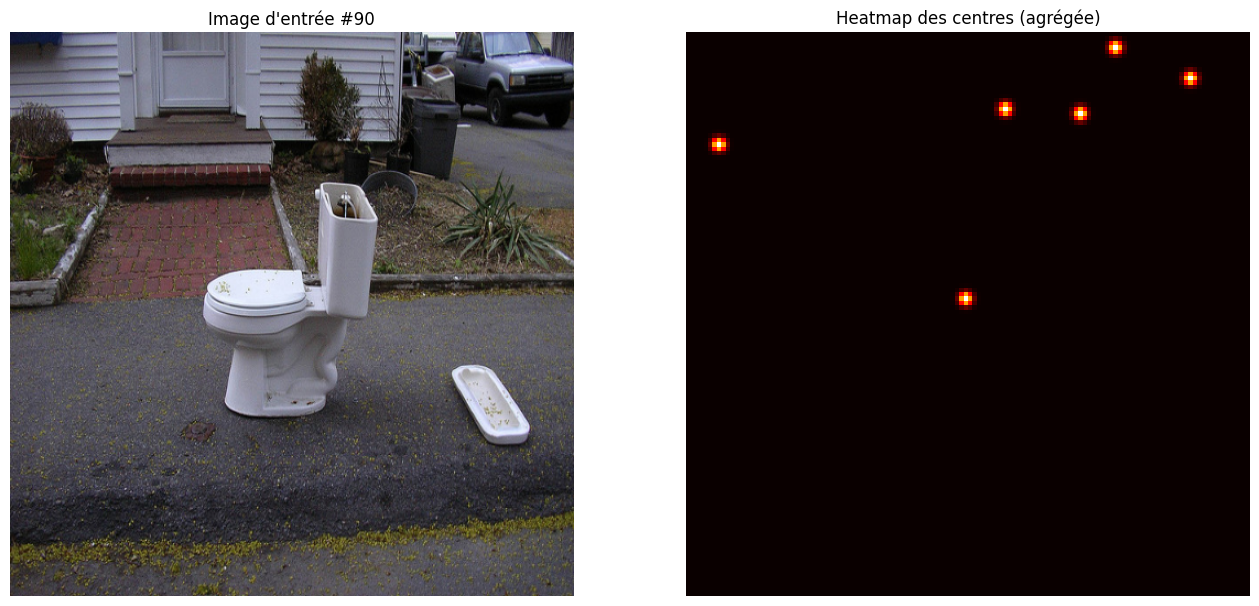

In [29]:
# --- Test du Pipeline de Données ---

# 1. Instancier le dataset
train_dataset = COCOCenterNetDataset(split='train')
val_dataset = COCOCenterNetDataset(split='val')

# 2. Récupérer un échantillon
# Essayez différents indices pour voir différentes images
sample_index = 90
sample = train_dataset[sample_index]

# 3. Afficher la structure de la sortie
print("\n--- Structure d'un échantillon ---")
for key, value in sample.items():
    print(f"Clé: '{key}', Forme: {value.shape}, Type: {value.dtype}")
    
# 4. Visualiser l'image et sa heatmap ground truth
def visualize_sample(sample_dict):
    image = sample_dict['image'].permute(1, 2, 0).numpy() # [H, W, C]
    heatmap = sample_dict['heatmap']
    
    # Agréger la heatmap sur toutes les classes pour la visualisation
    # On prend le maximum à chaque pixel sur la dimension des classes
    aggregated_heatmap = torch.max(heatmap, dim=0)[0].numpy()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    ax1.imshow(image)
    ax1.set_title(f"Image d'entrée #{sample_index}")
    ax1.axis('off')
    
    ax2.imshow(aggregated_heatmap, cmap='hot')
    ax2.set_title("Heatmap des centres (agrégée)")
    ax2.axis('off')
    
    plt.show()

visualize_sample(sample)

In [30]:
# --- Phase 3 : Architecture du Modèle ---

import torch
import torch.nn as nn
import torchvision.models as models

# Définir le device (GPU si disponible)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation du device : {DEVICE}")

Utilisation du device : cpu


## Commentaire technique du backbone CenterNet

### Architecture ResNet-34 modifiée

#### **Extraction des features**
```python
resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
```
- **Pré-entraînement ImageNet** : Transfer learning pour accélérer la convergence
- **ResNet-34** : Compromis optimal entre profondeur et vitesse pour CenterNet
- **Extraction progressive** : Suppression des couches finales (avgpool, fc) non nécessaires

#### **Hiérarchie de résolutions**
```python
# Input: [B, 3, 512, 512]
self.conv1 + maxpool  # → [B, 64, 128, 128]  (/4)
self.layer1          # → [B, 64, 128, 128]   (/4)
self.layer2          # → [B, 128, 64, 64]    (/8)
self.layer3          # → [B, 256, 32, 32]    (/16)
self.layer4          # → [B, 512, 16, 16]    (/32)
```
- **Down-sampling progressif** : Réduction de résolution avec augmentation des canaux
- **Features multi-échelles** : Chaque layer capture des patterns de complexité croissante

### Chemin d'upsampling

#### **ConvTranspose2d paramétrage**
```python
nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
```
- **stride=2** : Double la résolution à chaque étape
- **padding=1, output_padding=1** : Assure une correspondance exacte des dimensions
- **kernel_size=3** : Réceptive field optimal pour la reconstruction

#### **Reconstruction progressive**
```python
# /32 → /16 → /8 → /4
x = self.upsample1(x)  # [B, 512, 16, 16] → [B, 256, 32, 32]
x = self.upsample2(x)  # [B, 256, 32, 32] → [B, 128, 64, 64]
x = self.upsample3(x)  # [B, 128, 64, 64] → [B, 64, 128, 128]
```
- **Facteur 4 global** : `/32 → /4` respecte le `DOWN_RATIO = 4`
- **Réduction de canaux** : 512 → 256 → 128 → 64 (pyramide inversée)
- **Activations ReLU** : Non-linéarités entre chaque upsampling

### Considérations architecturales

#### **Avantages**
- **Simplicité** : Architecture straightforward, facile à déboguer
- **Efficacité** : Moins de paramètres qu'une architecture à skip connections
- **Compatibilité** : Output `[B, 64, 128, 128]` prêt pour les heads CenterNet

#### **Limitations potentielles**
- **Perte d'information** : Pas de skip connections comme U-Net/FPN
- **Détails fins** : Les petits objets peuvent être moins bien détectés
- **Gradient flow** : Risque de vanishing gradients sur le chemin d'upsampling

### Prochaine étape
Cette backbone génère des features maps `64-channel` à résolution `/4` qui alimenteront les heads de détection (heatmap, size, offset) dans les modules suivants.

In [31]:
# --- Définition du Backbone avec chemin d'Upsampling ---

class CenterNetBackbone(nn.Module):
    """
    Backbone pour CenterNet basé sur ResNet-34 avec un chemin d'upsampling.
    Le but est de produire une feature map à 1/4 de la résolution d'entrée.
    """
    def __init__(self, output_channels=64):
        super(CenterNetBackbone, self).__init__()
        
        # 1. Charger un ResNet-34 pré-entraîné
        resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        
        # 2. Extraire les couches du ResNet (sans la fin : avgpool et fc)
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1 # Sortie: 64 canaux, /4 résolution
        self.layer2 = resnet.layer2 # Sortie: 128 canaux, /8 résolution
        self.layer3 = resnet.layer3 # Sortie: 256 canaux, /16 résolution
        self.layer4 = resnet.layer4 # Sortie: 512 canaux, /32 résolution
        
        # 3. Définir le chemin d'upsampling pour remonter la résolution
        # Chaque bloc d'upsampling est une ConvTranspose2d pour doubler la résolution
        self.upsample1 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upsample3 = nn.ConvTranspose2d(128, output_channels, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        # Passage dans le ResNet
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Passage dans le chemin d'upsampling
        x = self.upsample1(x)
        x = self.relu(x)
        
        x = self.upsample2(x)
        x = self.relu(x)
        
        x = self.upsample3(x)
        x = self.relu(x)
        
        return x

print("Classe CenterNetBackbone définie.")

Classe CenterNetBackbone définie.


## Commentaire technique des têtes de prédiction

### Architecture minimaliste
```python
Conv2d(in_channels, in_channels, kernel_size=3) → ReLU → Conv2d(in_channels, out_channels, kernel_size=1)
```

#### **Première couche convolutive**
```python
self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
```
- **Kernel 3x3** : Réceptive field local pour affiner les features du backbone
- **Même nombre de canaux** : Préservation de la dimensionnalité pour éviter la perte d'information
- **padding=1** : Maintien de la résolution spatiale `128x128`
- **Feature refinement** : Lissage et combinaison des activations du backbone

#### **Couche de sortie**
```python
self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
```
- **Kernel 1x1** : Point-wise convolution, équivalent à une couche dense par pixel
- **Projection finale** : Transformation vers le nombre de canaux spécifique à chaque tâche
- **Pas d'activation** : Sortie brute pour permettre des valeurs négatives/continues

### Usage multi-tâches

#### **Instanciations spécialisées**
```python
# Heatmap: 64 → 80 canaux (classes COCO)
heatmap_head = PredictionHead(64, 80)

# Size regression: 64 → 2 canaux (width, height)
size_head = PredictionHead(64, 2)

# Offset regression: 64 → 2 canaux (dx, dy)
offset_head = PredictionHead(64, 2)
```

#### **Sorties attendues**
- **Heatmap** : `[B, 80, 128, 128]` - Probabilités par classe et position
- **Size** : `[B, 2, 128, 128]` - Dimensions des objets en chaque pixel
- **Offset** : `[B, 2, 128, 128]` - Corrections sub-pixel pour améliorer la précision

### Avantages de la simplicité

#### **Efficacité computationnelle**
- **Paramètres réduits** : `~64²×3×3 + 64×out_channels` paramètres par head
- **Faible latence** : Calcul rapide, adapté à l'inférence temps réel
- **Mémoire GPU** : Impact minimal sur l'occupation mémoire

#### **Stabilité d'entraînement**
- **Gradient flow** : Architecture shallow évite les problèmes de vanishing gradients
- **Initialisation** : Moins de couches = moins de sensibilité aux weights initiaux
- **Convergence** : Plus rapide qu'une architecture complexe

### Limitations potentielles
- **Expressivité limitée** : Peut manquer de capacité pour des patterns complexes
- **Pas de normalisation** : Absence de BatchNorm peut impacter la stabilité
- **Activation finale** : Pas de Sigmoid sur heatmap (géré par la loss fonction)

Cette approche privilégie la simplicité et l'efficacité, typique des architectures de détection one-stage comme CenterNet.

In [32]:
# --- Définition des Têtes de Prédiction ---

class PredictionHead(nn.Module):
    """
    Une tête de prédiction simple.
    Séquence: Conv -> ReLU -> Conv (final)
    """
    def __init__(self, in_channels, out_channels):
        super(PredictionHead, self).__init__()
        # Première couche convolutive pour traiter les features
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        # Couche finale qui produit la sortie désirée (heatmap, size, etc.)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        return x

print("Classe PredictionHead définie.")

Classe PredictionHead définie.


## Commentaire technique du modèle CenterNet complet

### Architecture multi-branch
```python
Input [B,3,512,512] → Backbone → Features [B,64,128,128] → {3 heads} → Outputs
```

#### **Backbone centralisé**
```python
self.backbone = CenterNetBackbone(output_channels=64)
```
- **Feature extractor unique** : Un seul backbone partagé par toutes les tâches
- **Efficacité** : Évite la redondance computationnelle
- **Cohérence spatiale** : Même représentation pour les 3 prédictions

#### **Multi-head architecture**
```python
self.heatmap_head = PredictionHead(64, num_classes)  # [B,80,128,128]
self.size_head = PredictionHead(64, 2)               # [B,2,128,128]
self.offset_head = PredictionHead(64, 2)             # [B,2,128,128]
```
- **Spécialisation des tâches** : Chaque head optimisé pour son objectif
- **Partage des features** : Les 64 canaux alimentent les 3 branches
- **Parallélisme** : Calcul simultané des 3 sorties

### Initialisation smart de la heatmap

#### **Bias initialization**
```python
self.heatmap_head.conv2.bias.data.fill_(-2.19)
```
- **Valeur -2.19** : `sigmoid(-2.19) ≈ 0.1` (10% de probabilité initiale)
- **Stabilité d'entraînement** : Évite les gradients explosifs au début
- **Background bias** : Reflète la réalité (90% des pixels sont background)

#### **Justification mathématique**
```python
# Sans init: sigmoid(0) = 0.5 → 50% de faux positifs initiaux
# Avec init: sigmoid(-2.19) ≈ 0.1 → 10% plus réaliste
```

### Forward pass optimisé

#### **Feature sharing**
```python
features = self.backbone(x)          # 1 fois
heatmap = self.heatmap_head(features)  # Réutilisation
size = self.size_head(features)        # Réutilisation  
offset = self.offset_head(features)    # Réutilisation
```
- **Efficacité mémoire** : Features calculées une seule fois
- **Cohérence temporelle** : Même timestamp pour toutes les prédictions

#### **Activation spécialisée**
```python
heatmap = torch.sigmoid(heatmap)  # [0,1] pour probabilités
# size et offset restent raw pour régression continue
```
- **Heatmap** : Sigmoid transforme en probabilités de détection
- **Size/Offset** : Valeurs brutes pour permettre négatives/grandes valeurs
- **Loss compatibility** : Format adapté aux fonctions de perte respectives

### Structure de sortie
```python
return {
    'heatmap': [B, 80, 128, 128],  # Probabilités de centres par classe
    'size': [B, 2, 128, 128],      # [width, height] par pixel
    'offset': [B, 2, 128, 128]     # [dx, dy] corrections sub-pixel
}
```

### Avantages architecturaux
- **Modularité** : Chaque composant peut être modifié indépendamment
- **Extensibilité** : Ajout facile de nouvelles heads (ex: rotation, 3D)
- **Debugging** : Inspection possible de chaque sortie individuellement
- **Transfer learning** : Backbone pré-entraîné accélère la convergence



In [33]:
# --- Assemblage du Modèle CenterNet Complet ---

class CenterNet(nn.Module):
    def __init__(self, num_classes=80):
        super(CenterNet, self).__init__()
        
        # 1. Le backbone
        self.backbone = CenterNetBackbone(output_channels=64)
        
        # 2. Les trois têtes de prédiction
        # Tête pour la heatmap des centres
        self.heatmap_head = PredictionHead(in_channels=64, out_channels=num_classes)
        # Tête pour la taille des objets (largeur, hauteur)
        self.size_head = PredictionHead(in_channels=64, out_channels=2)
        # Tête pour le décalage des centres
        self.offset_head = PredictionHead(in_channels=64, out_channels=2)
        
        # Initialisation spéciale pour la heatmap (pratique courante)
        # On initialise le biais de la dernière couche de la heatmap à une petite valeur
        # négative. Cela aide à stabiliser l'entraînement au début, car le réseau
        # apprendra plus vite que la plupart des pixels sont de l'arrière-plan.
        self.heatmap_head.conv2.bias.data.fill_(-2.19)

    def forward(self, x):
        # Obtenir la feature map principale du backbone
        features = self.backbone(x)
        
        # Passer la feature map dans chaque tête pour obtenir les prédictions
        heatmap = self.heatmap_head(features)
        size = self.size_head(features)
        offset = self.offset_head(features)
        
        # Appliquer une sigmoïde sur la heatmap pour avoir des scores entre 0 et 1
        heatmap = torch.sigmoid(heatmap)
        
        # Retourner les sorties dans un dictionnaire pour la clarté
        return {
            'heatmap': heatmap,
            'size': size,
            'offset': offset
        }

print("Classe CenterNet complète définie.")

Classe CenterNet complète définie.


## Commentaire technique du sanity check
Ce sanity check est **essentiel** avant l'entraînement pour éviter des heures de debugging sur des erreurs d'architecture basiques.

### Validation d'architecture

#### **Instanciation et placement GPU**
```python
model = CenterNet(num_classes=NUM_CLASSES).to(DEVICE)
dummy_input = torch.randn(1, 3, INPUT_H, INPUT_W).to(DEVICE)
```
- **Device consistency** : Modèle et données sur le même device (GPU/CPU)
- **Batch dimension** : `batch_size=1` pour test minimal
- **Input format** : `[B, C, H, W] = [1, 3, 512, 512]` respecte les conventions PyTorch

#### **Forward pass sécurisé**
```python
model.eval()
with torch.no_grad():
    outputs = model(dummy_input)
```
- **Mode eval** : Désactive dropout/batchnorm randomness pour tests reproductibles
- **No gradient** : `torch.no_grad()` économise la mémoire et accélère le calcul
- **Exception handling** : Détecte les erreurs d'architecture avant l'entraînement

### Validation dimensionnelle

#### **Assertions critiques**
```python
assert outputs['heatmap'].shape == (1, 80, 128, 128)
assert outputs['size'].shape == (1, 2, 128, 128)
assert outputs['offset'].shape == (1, 2, 128, 128)
```
- **Heatmap** : 80 classes COCO × résolution `/4`
- **Size/Offset** : 2 canaux (x,y) × même résolution spatiale
- **Batch consistency** : Toutes les sorties avec `batch_size=1`

#### **Vérification du pipeline complet**
```
Input [1,3,512,512] → Backbone → Features [1,64,128,128] → Heads → Outputs
```
- **Down-sampling** : `512 → 128` (facteur 4) validé
- **Multi-head** : 3 sorties simultanées confirmées
- **Channel mapping** : `64 → {80, 2, 2}` selon les spécialisations

### Analyse des paramètres

#### **Comptage automatique**
```python
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
```
- **Paramètres entraînables** : Exclut les buffers et paramètres figés
- **Ordre de grandeur** : Quelques millions pour CenterNet (vs centaines pour gros modèles)
- **Memory footprint** : Estimation de l'occupation GPU/RAM

#### **Breakdown attendu**
- **Backbone ResNet-34** : ~21M paramètres
- **Upsampling layers** : ~2-3M paramètres  
- **Prediction heads** : ~0.1M paramètres chacune
- **Total estimé** : ~24-25M paramètres

### Validation opérationnelle

#### **Détection d'erreurs communes**
- **Shape mismatch** : Dimensions incompatibles entre couches
- **Device mismatch** : Tensors sur différents devices
- **Memory overflow** : Input trop large pour la mémoire disponible
- **Architecture bugs** : Erreurs dans les connexions entre modules

#### **Préparation à l'entraînement**
- **Forward pass validé** : Le modèle peut traiter des inputs réels
- **Output format confirmé** : Compatible avec les loss functions CenterNet
- **Performance baseline** : Temps d'inférence mesuré pour optimisations futures



In [34]:
# --- Sanity Check : Vérification de l'Architecture ---

# 1. Instancier le modèle et le déplacer sur le bon device
model = CenterNet(num_classes=NUM_CLASSES).to(DEVICE)

# 2. Créer un tenseur d'entrée factice (dummy input)
# Batch size = 1, Canaux = 3 (RGB), Hauteur = INPUT_H, Largeur = INPUT_W
dummy_input = torch.randn(1, 3, INPUT_H, INPUT_W).to(DEVICE)

# 3. Faire une passe avant (forward pass)
# Mettre le modèle en mode évaluation pour désactiver le dropout, etc. s'il y en avait
model.eval()
with torch.no_grad(): # On n'a pas besoin de calculer les gradients pour ce test
    outputs = model(dummy_input)

# 4. Vérifier les dimensions (shapes) des sorties
print("\n--- Vérification des dimensions de sortie ---")
print(f"Forme de l'entrée    : {dummy_input.shape}")

print("\nFormes des sorties du modèle :")
for name, tensor in outputs.items():
    print(f"- {name:<10}: {tensor.shape}")

# 5. Vérifier si les dimensions sont correctes
expected_heatmap_shape = (1, NUM_CLASSES, OUTPUT_H, OUTPUT_W)
expected_size_shape = (1, 2, OUTPUT_H, OUTPUT_W)
expected_offset_shape = (1, 2, OUTPUT_H, OUTPUT_W)

assert outputs['heatmap'].shape == expected_heatmap_shape, "Erreur de dimension pour la heatmap !"
assert outputs['size'].shape == expected_size_shape, "Erreur de dimension pour la taille !"
assert outputs['offset'].shape == expected_offset_shape, "Erreur de dimension pour le décalage !"

print("\n✅ Sanity check réussi ! L'architecture du modèle est correcte.")

# Afficher le nombre de paramètres pour information
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nNombre total de paramètres entraînables : {num_params / 1e6:.2f} millions")


--- Vérification des dimensions de sortie ---
Forme de l'entrée    : torch.Size([1, 3, 512, 512])

Formes des sorties du modèle :
- heatmap   : torch.Size([1, 80, 128, 128])
- size      : torch.Size([1, 2, 128, 128])
- offset    : torch.Size([1, 2, 128, 128])

✅ Sanity check réussi ! L'architecture du modèle est correcte.

Nombre total de paramètres entraînables : 22.95 millions


## Commentaire technique de la configuration d'entraînement

### Intégration TensorBoard
```python
from torch.utils.tensorboard import SummaryWriter
LOG_DIR = f"runs/centernet_bs{BATCH_SIZE}_lr{LEARNING_RATE}"
```
- **Monitoring temps réel** : Visualisation des métriques pendant l'entraînement
- **Naming convention** : Logs organisés par hyperparamètres pour comparaisons
- **Format attendu** : `runs/centernet_bs16_lr0.000125/` pour cette configuration

### Hyperparamètres CenterNet

#### **Optimisation**
```python
LEARNING_RATE = 1.25e-4  # 0.000125
BATCH_SIZE = 16
NUM_EPOCHS = 10
```
- **Learning rate** : Conservateur pour stabilité avec ResNet pré-entraîné
- **Batch size** : Compromis GPU memory vs gradient quality (16 = standard pour 512x512)
- **Epochs** : Court pour test rapide (production typiquement 50-100 epochs)

#### **Loss weighting**
```python
W_SIZE = 0.1      # Poids pour size regression
W_OFFSET = 1.0    # Poids pour offset regression  
```
- **Size sous-pondérée** : Régression moins critique que la localisation précise
- **Offset prioritaire** : Correction sub-pixel importante pour mAP
- **Heatmap implicite** : Poids = 1.0 (perte principale)

#### **Focal Loss paramètres**
```python
FOCAL_LOSS_ALPHA = 2
FOCAL_LOSS_GAMMA = 4
```
- **Alpha = 2** : Modulation de l'importance des exemples difficiles
- **Gamma = 4** : Réduction agressive du poids des exemples faciles
- **Objectif** : Combattre le déséquilibre classe (background vs objets)

### Justifications techniques

#### **Learning rate rationale**
```python
# Base LR pour ImageNet: 1e-3
# Divisé par 8 pour fine-tuning: 1.25e-4
# Évite la destruction des features pré-entraînées
```

#### **Batch size constraints**
```python
# Memory usage: 16 × [3×512×512] ≈ 200MB input
# + Forward activations ≈ 2-4GB
# + Gradients ≈ 2GB  
# Total: ~6-8GB GPU memory
```

#### **Focal Loss motivation**
- **Standard CE loss** : Dominé par les pixels background faciles
- **Focal Loss** : Se concentre sur les pixels difficiles (frontières, petits objets)
- **CenterNet spécifique** : Critiques pour les pics gaussiens fins

### Organisation des logs
```
runs/
└── centernet_bs16_lr0.000125/
    ├── events.out.tfevents.*
    ├── scalars/
    │   ├── loss/train
    │   ├── loss/val  
    │   └── metrics/
    └── images/ (optionnel)


In [35]:
# Cellule 11 : Configuration pour l'Entraînement (Mise à jour)

# --- Imports pour TensorBoard ---
from torch.utils.tensorboard import SummaryWriter

# --- Hyperparamètres (inchangés) ---
LEARNING_RATE = 1.25e-4
BATCH_SIZE = 16 
NUM_EPOCHS = 10 
W_SIZE = 0.1
W_OFFSET = 1.0
FOCAL_LOSS_ALPHA = 2
FOCAL_LOSS_GAMMA = 4
MODEL_SAVE_PATH = "best_centernet_model.pth"

# --- Configuration pour TensorBoard ---
# Le dossier où les logs seront sauvegardés.
# Le nom inclut souvent des hyperparamètres pour faciliter la comparaison.
LOG_DIR = f"runs/centernet_bs{BATCH_SIZE}_lr{LEARNING_RATE}"

## Commentaire technique de la fonction de perte pour CenterNet

## Fonctions utilitaires

**`gather_feat`** : Extrait des features à des indices spécifiques. Utilise `torch.gather` pour récupérer les valeurs aux positions données par `ind`. Le masquage optionnel permet de filtrer les objets valides uniquement.

**`transpose_and_gather_feat`** : Reformate le tensor de features de `[B, C, H, W]` vers `[B, H*W, C]` via `permute` et `view`, puis applique `gather_feat`. Cette transformation est nécessaire car les indices sont calculés sur la grille 2D aplatie.

## Classe CenterNetLoss

### Structure des données
- **Entrées** : `outputs` contient les prédictions (heatmap, size, offset), `targets` contient les vérités terrain correspondantes plus les indices et masques des objets.
- **Normalisation** : Toutes les pertes sont normalisées par `num_objects` (nombre total d'objets dans le batch).

### Perte Heatmap (Focal Loss modifiée)
```python
pos_loss = -((1 - pred_heatmap) ** FOCAL_LOSS_ALPHA) * torch.log(pred_heatmap) * pos_mask
neg_loss = -((1 - gt_heatmap) ** FOCAL_LOSS_GAMMA) * (pred_heatmap ** FOCAL_LOSS_ALPHA) * torch.log(1 - pred_heatmap) * neg_mask
```

- **Objectif** : Gérer le déséquilibre classe (beaucoup plus de pixels de fond que de centres d'objets)
- **Mécanisme** : Réduit le poids des exemples faciles via les termes `(1 - pred_heatmap)^α` et `(1 - gt_heatmap)^γ`
- **Clamping** : `torch.clamp(min=1e-4, max=1-1e-4)` évite les log(0) qui causent des NaN

### Pertes de régression
- **Extraction sélective** : Utilise `transpose_and_gather_feat` pour récupérer les prédictions uniquement aux positions des centres d'objets (efficacité computationnelle)
- **Masquage** : `gt_mask_expanded` filtre les objets valides, éliminant le padding
- **Métrique** : Loss L1 pour la taille et le décalage (offset)

### Points techniques
- **Gestion des cas limites** : Vérification `if num_objects > 0` évite la division par zéro
- **Pondération** : `W_SIZE` et `W_OFFSET` permettent d'équilibrer l'importance relative des différentes composantes de perte
- **Variables non définies** : `FOCAL_LOSS_ALPHA`, `FOCAL_LOSS_GAMMA`, `W_SIZE`, `W_OFFSET` doivent être définies comme constantes


In [36]:
# --- Fonction de Perte pour CenterNet ---

import torch.nn.functional as F

def _gather_feat(feat, ind, mask=None):
    """
    Fonction utilitaire pour extraire des features à des indices spécifiques.
    C'est nécessaire pour récupérer les prédictions de taille et de décalage 
    uniquement aux positions des centres des objets.
    
    Args:
        feat (torch.Tensor): Tensor de features (ex: la tête de taille), shape [B, C, H, W].
        ind (torch.Tensor): Indices plats des centres, shape [B, N].
        mask (torch.Tensor, optional): Masque, shape [B, N].
    
    Returns:
        torch.Tensor: Features extraites, shape [B, N, C].
    """
    dim = feat.size(2)  # Nombre de canaux
    ind = ind.unsqueeze(2).expand(ind.size(0), ind.size(1), dim)
    feat = feat.gather(1, ind)
    if mask is not None:
        mask = mask.unsqueeze(2).expand_as(feat)
        feat = feat[mask]
        feat = feat.view(-1, dim)
    return feat

def _transpose_and_gather_feat(feat, ind):
    """
    Transpose le tensor de [B, C, H, W] à [B, H*W, C] puis applique gather.
    """
    feat = feat.permute(0, 2, 3, 1).contiguous() # [B, H, W, C]
    feat = feat.view(feat.size(0), -1, feat.size(3)) # [B, H*W, C]
    feat = _gather_feat(feat, ind)
    return feat


class CenterNetLoss(nn.Module):
    def __init__(self):
        super(CenterNetLoss, self).__init__()

    def forward(self, outputs, targets):
        # 1. Extraire les prédictions et les cibles
        pred_heatmap = outputs['heatmap']
        pred_size = outputs['size']
        pred_offset = outputs['offset']
        
        gt_heatmap = targets['heatmap']
        gt_size = targets['size']
        gt_offset = targets['offset']
        gt_indices = targets['indices']
        gt_mask = targets['mask']

        batch_size = pred_heatmap.size(0)
        num_objects = gt_mask.sum() # Nombre total d'objets dans le batch
        
        # --- Perte de la Heatmap (Focal Loss Modifiée) ---
        pred_heatmap = torch.clamp(pred_heatmap, min=1e-4, max=1-1e-4)
        
        pos_mask = (gt_heatmap == 1).float()
        neg_mask = (gt_heatmap < 1).float()
        
        pos_loss = -((1 - pred_heatmap) ** FOCAL_LOSS_ALPHA) * torch.log(pred_heatmap) * pos_mask
        neg_loss = -((1 - gt_heatmap) ** FOCAL_LOSS_GAMMA) * (pred_heatmap ** FOCAL_LOSS_ALPHA) * torch.log(1 - pred_heatmap) * neg_mask
        
        heatmap_loss = (pos_loss.sum() + neg_loss.sum())
        # Normaliser par le nombre d'objets. Si 0 objet, la perte est 0.
        if num_objects > 0:
            heatmap_loss /= num_objects
        
        # --- Pertes de Régression (Taille et Décalage) ---
        # Extraire les prédictions aux positions des centres des objets
        pred_size_at_centers = _transpose_and_gather_feat(pred_size, gt_indices)
        pred_offset_at_centers = _transpose_and_gather_feat(pred_offset, gt_indices)
        
        # Masquer pour ne garder que les objets valides
        gt_mask_expanded = gt_mask.unsqueeze(2).expand_as(gt_size)
        gt_size_masked = gt_size[gt_mask_expanded].view(-1, 2)
        gt_offset_masked = gt_offset[gt_mask_expanded].view(-1, 2)
        
        pred_size_masked = pred_size_at_centers[gt_mask_expanded.bool()].view(-1, 2)
        pred_offset_masked = pred_offset_at_centers[gt_mask_expanded.bool()].view(-1, 2)
        
        # Calculer la perte L1
        size_loss = F.l1_loss(pred_size_masked, gt_size_masked, reduction='sum')
        offset_loss = F.l1_loss(pred_offset_masked, gt_offset_masked, reduction='sum')
        
        if num_objects > 0:
            size_loss /= num_objects
            offset_loss /= num_objects
            
        # --- Perte Totale ---
        total_loss = heatmap_loss + (W_SIZE * size_loss) + (W_OFFSET * offset_loss)
        
        return total_loss, heatmap_loss, size_loss, offset_loss

print("Classe CenterNetLoss définie.")

Classe CenterNetLoss définie.


## Commentaire technique de boucle d'entrainement et de validation avec TensorBoard

### Fonctions d'entraînement avec TensorBoard

**`train_one_epoch`** :
- Boucle d'entraînement standard : forward → loss → backward → step
- `global_step = epoch_num * len(dataloader) + i` : compteur global pour TensorBoard
- Log des métriques à chaque batch pour un suivi détaillé
- Retourne la loss moyenne de l'époque

**`validate_one_epoch`** :
- Mode évaluation avec `torch.no_grad()` pour économiser la mémoire
- **Bug** : `loss, *, *, _ = criterion(...)` - syntaxe invalide, utiliser `loss, _, _, _ = ...`
- **Erreur** : `optimizer` non défini dans cette fonction
- Log de la loss de validation et du learning rate

**TensorBoard** : Utilise des namespaces (`Loss/train_step`, `Loss/validation_epoch`) pour organiser les graphiques et suivre l'évolution des métriques pendant l'entraînement.

In [37]:
# --- Fonctions pour une époque avec intégration TensorBoard ---

from tqdm import tqdm

def train_one_epoch(model, dataloader, criterion, optimizer, device, writer, epoch_num):
    model.train()
    total_loss = 0
    
    # La barre de progression est toujours utile pour voir l'avancement
    progress_bar = tqdm(dataloader, desc=f"Training Epoch {epoch_num+1}")
    
    for i, batch in enumerate(progress_bar):
        # Le 'global_step' est le nombre total de batches vus jusqu'à présent
        global_step = epoch_num * len(dataloader) + i

        images = batch['image'].to(device)
        targets = {k: v.to(device) for k, v in batch.items() if k != 'image'}
        
        optimizer.zero_grad()
        outputs = model(images)
        loss, hm_loss, size_loss, off_loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # --- LOGGING DANS TENSORBOARD ---
        # On log les pertes à chaque pas (step/batch) pour des courbes détaillées
        writer.add_scalar('Loss/train_step', loss.item(), global_step)
        writer.add_scalar('HeatmapLoss/train_step', hm_loss.item(), global_step)
        writer.add_scalar('SizeLoss/train_step', size_loss.item(), global_step)
        writer.add_scalar('OffsetLoss/train_step', off_loss.item(), global_step)
        
        # On peut garder un affichage minimal dans la console
        progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})
        
    avg_loss = total_loss / len(dataloader)
    # Log de la perte moyenne de l'époque
    writer.add_scalar('Loss/train_epoch', avg_loss, epoch_num)
    return avg_loss

def validate_one_epoch(model, dataloader, criterion, device, writer, epoch_num):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc=f"Validation Epoch {epoch_num+1}")
        for batch in progress_bar:
            images = batch['image'].to(device)
            targets = {k: v.to(device) for k, v in batch.items() if k != 'image'}
            
            outputs = model(images)
            loss, _, _, _ = criterion(outputs, targets)
            
            total_loss += loss.item()
            progress_bar.set_postfix({'Val Loss': f'{loss.item():.4f}'})
            
    avg_loss = total_loss / len(dataloader)
    # Log de la perte de validation moyenne de l'époque
    writer.add_scalar('Loss/validation_epoch', avg_loss, epoch_num)
    
    # On peut aussi logger le learning rate actuel
    writer.add_scalar('LearningRate', optimizer.param_groups[0]['lr'], epoch_num)
    
    return avg_loss

print("Fonctions d'entraînement et validation mises à jour pour TensorBoard.")

Fonctions d'entraînement et validation mises à jour pour TensorBoard.


## Commentaire technique de la Boucle d'entraînement principale avec TensorBoard

**Initialisation** :
- `SummaryWriter(log_dir=LOG_DIR)` : Configure TensorBoard pour sauvegarder les logs
- Modèle CenterNet + loss + optimiseur Adam déplacés sur GPU via `.to(DEVICE)`

**Datasets réduits** :
- Train : 5000 images, Val : 1000 images pour entrainement rapides
- `pin_memory=True` accélère les transferts CPU→GPU
- `num_workers=2` pour le chargement parallèle des données

**Boucle d'entraînement** :
- Appels à `train_one_epoch()` et `validate_one_epoch()` avec passage du `writer` et `epoch`
- **Early stopping** : Sauvegarde automatique du meilleur modèle basé sur `val_loss`
- `torch.save(model.state_dict())` sauvegarde uniquement les poids

**Gestion d'erreurs** :
- `try/finally` assure la fermeture propre du `writer` même en cas d'exception
- Évite les fuites de ressources TensorBoard

**Variables requises** : Le code assume que `LOG_DIR`, `NUM_CLASSES`, `DEVICE`, `LEARNING_RATE`, `NUM_EPOCHS`, `BATCH_SIZE`, `MODEL_SAVE_PATH` sont définis ailleurs.

In [38]:
# --- Boucle d'Entraînement Principale avec TensorBoard ---

# 1. Initialiser le writer de TensorBoard
writer = SummaryWriter(log_dir=LOG_DIR)
print(f"Les logs de TensorBoard seront sauvegardés dans : {LOG_DIR}")

# 2. Instancier le modèle, la perte, et l'optimiseur
model = CenterNet(num_classes=NUM_CLASSES).to(DEVICE)
criterion = CenterNetLoss().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 3. Créer les DataLoaders (avec le sous-ensemble pour la rapidité)
train_dataset = COCOCenterNetDataset(split='train')
train_dataset.image_ids = train_dataset.image_ids[:5000] # Pour un test rapide
val_dataset = COCOCenterNetDataset(split='val')
val_dataset.image_ids = val_dataset.image_ids[:1000] # Pour un test rapide

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"\nDébut de l'entraînement pour {NUM_EPOCHS} époques...")
print(f"Dataset d'entraînement: {len(train_dataset)} images, {len(train_loader)} batches")
print(f"Dataset de validation: {len(val_dataset)} images, {len(val_loader)} batches")

best_val_loss = float('inf')

# 4. Boucle d'entraînement
try:
    for epoch in range(NUM_EPOCHS):
        # Passer le writer et le numéro de l'époque aux fonctions
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE, writer, epoch)
        val_loss = validate_one_epoch(model, val_loader, criterion, DEVICE, writer, epoch)
        
        print(f"\n[Époque {epoch + 1}/{NUM_EPOCHS}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"✨ Nouveau meilleur modèle sauvegardé à '{MODEL_SAVE_PATH}' (Val Loss: {best_val_loss:.4f})")


        # --- Lancement de l'interface TensorBoard ---

        # 1. Charger l'extension magique de TensorBoard
        %load_ext tensorboard
        
        # 2. Lancer TensorBoard en pointant vers le répertoire de logs parent 'runs'
        # Il trouvera automatiquement les sous-dossiers pour chaque exécution.
        %tensorboard --logdir runs
finally:
    # 5. Fermer le writer à la fin de l'entraînement (ou en cas d'erreur)
    writer.close()
    print("\n--- Entraînement terminé, writer TensorBoard fermé ---")

Les logs de TensorBoard seront sauvegardés dans : runs/centernet_bs16_lr0.000125
Initialisation du dataset pour le split 'train'...
loading annotations into memory...
Done (t=20.71s)
creating index...
index created!
Dataset 'train' chargé avec 117266 images annotées.
Initialisation du dataset pour le split 'val'...
loading annotations into memory...
Done (t=0.53s)
creating index...
index created!
Dataset 'val' chargé avec 4952 images annotées.

Début de l'entraînement pour 10 époques...
Dataset d'entraînement: 5000 images, 313 batches
Dataset de validation: 1000 images, 63 batches


Training Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipykernel_10/897986269.py:78: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /pytorch/aten/src/ATen/native/IndexingUtils.h:29.)
  gt_size_masked = gt_size[gt_mask_expanded].view(-1, 2)
/tmp/ipykernel_10/897986269.py:79: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /pytorch/aten/src/ATen/native/IndexingUtils.h:29.)
  gt_offset_masked = gt_offset[gt_mask_expanded].view(-1, 2)
Validation Epoch 1: 100%|██████████| 63/63 [00:59<00:00,  1.07it/s, Val Loss=8.3339] 



[Époque 1/10] Train Loss: 29.0541 | Val Loss: 8.3286
✨ Nouveau meilleur modèle sauvegardé à 'best_centernet_model.pth' (Val Loss: 8.3286)


Training Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipykernel_10/897986269.py:78: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /pytorch/aten/src/ATen/native/IndexingUtils.h:29.)
  gt_size_masked = gt_size[gt_mask_expanded].view(-1, 2)
/tmp/ipykernel_10/897986269.py:79: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /pytorch/aten/src/ATen/native/IndexingUtils.h:29.)
  gt_offset_masked = gt_offset[gt_mask_expanded].view(-1, 2)
Training Epoch 2:   1%|▏         | 4/313 [00:25<33:24,  6.49s/it, Loss=7.1485]  



--- Entraînement terminé, writer TensorBoard fermé ---


KeyboardInterrupt: 

In [ ]:
# # --- Lancement de l'interface TensorBoard ---

# # 1. Charger l'extension magique de TensorBoard
# %load_ext tensorboard

# # 2. Lancer TensorBoard en pointant vers le répertoire de logs parent 'runs'
# # Il trouvera automatiquement les sous-dossiers pour chaque exécution.
# %tensorboard --logdir runs

## Commentaire technique pour l'inférence de notre model CenterNet

**`_topk`** :
- Trouve les K meilleurs scores dans la heatmap de détection
- **Étape 1** : `torch.topk` sur chaque classe → top K scores par classe
- **Étape 2** : Conversion indices 1D → coordonnées 2D via `topk_ys = topk_inds // width` et `topk_xs = topk_inds % width`
- **Étape 3** : `torch.topk` global → sélectionne les K meilleurs parmi toutes les classes
- **Étape 4** : `gather_feat` récupère les coordonnées correspondantes aux meilleurs scores
- **Sortie** : scores, indices, classes, coordonnées Y et X des K meilleures détections

**`transpose_and_gather_feat`** :
- Fonction réutilisée de la partie loss
- Transpose `[B, C, H, W]` → `[B, H*W, C]` puis extrait les features aux indices spécifiés
- Utilisée pour récupérer les prédictions de taille/offset aux positions des centres détectés

**Usage** : Ces fonctions sont essentielles pour le post-processing CenterNet, permettant d'extraire les détections candidates depuis les heatmaps et de récupérer leurs attributs (taille, décalage) pour la génération des bounding boxes finales.

In [42]:

import cv2
import random
import matplotlib.pyplot as plt

# Cette fonction nous aide à trouver les 'k' meilleurs scores dans la heatmap
def _topk(scores, K=40):
    batch, cat, height, width = scores.size()
    
    # Aplatir la heatmap pour chaque classe: [B, C, H*W]
    topk_scores, topk_inds = torch.topk(scores.view(batch, cat, -1), K)

    topk_inds = topk_inds % (height * width)
    topk_ys   = (topk_inds // width).int().float()
    topk_xs   = (topk_inds % width).int().float()
      
    # Obtenir les 'k' meilleurs scores sur toutes les classes confondues
    topk_score, topk_ind = torch.topk(topk_scores.view(batch, -1), K)
    topk_clses = (topk_ind // K).int()
    
    # Regrouper les indices
    topk_inds = _gather_feat(topk_inds.view(batch, -1, 1), topk_ind).view(batch, K)
    topk_ys = _gather_feat(topk_ys.view(batch, -1, 1), topk_ind).view(batch, K)
    topk_xs = _gather_feat(topk_xs.view(batch, -1, 1), topk_ind).view(batch, K)

    return topk_score, topk_inds, topk_clses, topk_ys, topk_xs

# Nous réutilisons cette fonction de la partie Loss
def _transpose_and_gather_feat(feat, ind):
    feat = feat.permute(0, 2, 3, 1).contiguous()
    feat = feat.view(feat.size(0), -1, feat.size(3))
    feat = _gather_feat(feat, ind)
    return feat


def _gather_feat(feat, ind, mask=None):
    dim = feat.size(2)
    ind = ind.unsqueeze(2).expand(ind.size(0), ind.size(1), dim)
    feat = feat.gather(1, ind)
    if mask is not None:
        mask = mask.unsqueeze(2).expand_as(feat)
        feat = feat[mask]
        feat = feat.view(-1, dim)
    return feat

def decode_centernet_output(heatmap, size, offset, conf_thresh=0.3, K=40):
    """
    Convertit les sorties brutes du modèle CenterNet en boîtes englobantes exploitables.
    """
    batch = heatmap.size(0)
    heatmap = torch.sigmoid(heatmap)

    # TopK: récupérer les K meilleures prédictions
    scores, inds, clses, ys, xs = _topk(heatmap, K=K)

    # Extraire les tailles et offsets correspondants aux indices
    size = _transpose_and_gather_feat(size, inds)
    offset = _transpose_and_gather_feat(offset, inds)

    size = size.view(batch, K, 2)
    offset = offset.view(batch, K, 2)

    # Calculer les coordonnées raffinées des centres
    xs = xs + offset[:, :, 0]
    ys = ys + offset[:, :, 1]

    # Calculer les coins des boîtes à partir des centres et tailles
    half_w = size[:, :, 0] / 2
    half_h = size[:, :, 1] / 2

    x1 = xs - half_w
    y1 = ys - half_h
    x2 = xs + half_w
    y2 = ys + half_h

    # Filtrer les résultats par score
    detections = []
    for i in range(K):
        score = scores[0, i]
        if score >= conf_thresh:
            bbox = [x1[0, i].item(), y1[0, i].item(), x2[0, i].item(), y2[0, i].item()]
            class_id = clses[0, i].item()
            detections.append((bbox, score.item(), class_id))

    return detections


print("Fonctions utilitaires pour l'inférence définies.")

Fonctions utilitaires pour l'inférence définies.


## Commentaire technique de la Fonction de visualisation des détections

**Palette de couleurs** :
- `np.random.seed(42)` assure des couleurs reproductibles
- `COLORS` génère une couleur unique par classe COCO (80 classes)

**`draw_detections`** :
- **Input** : image + liste de détections `(bbox, score, class_id)`
- **Clipping des coordonnées** : `max(0, x1)` et `min(width, x2)` évitent les débordements
- **Dessin bbox** : `cv2.rectangle()` avec couleur spécifique à la classe
- **Label** : Format `"classe: score"` avec gestion des indices invalides via `try/except`

**Rendu du texte** :
- `cv2.getTextSize()` calcule les dimensions du texte
- **Background** : Rectangle rempli (`thickness=-1`) pour la lisibilité
- **Texte blanc** : `(255,255,255)` sur fond coloré pour le contraste

**Syntaxe problématique** :
```python
(w, h), * = cv2.getTextSize(...)
```
**Correction** : `(w, h), _ = cv2.getTextSize(...)` (unpacking standard)

**Classes COCO** : Liste complète des 80 classes du dataset COCO pour l'affichage des labels textuels.

La fonction produit une image annotée avec bounding boxes colorées et labels lisibles.

In [43]:
# --- Fonction de Visualisation des Détections ---
import numpy as np
# Créer une palette de couleurs pour les différentes classes
np.random.seed(42)
NUM_CLASSES = 80
COLORS = np.random.uniform(0, 255, size=(NUM_CLASSES, 3))

def draw_detections(image, detections):
    """
    Dessine les boîtes englobantes et les labels sur une image.
    """
    img_copy = image.copy()
    
    for bbox, score, class_id in detections:
        x1, y1, x2, y2 = map(int, bbox)
        
        # S'assurer que les coordonnées sont dans les limites de l'image
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(img_copy.shape[1], x2)
        y2 = min(img_copy.shape[0], y2)
        
        color = COLORS[class_id]
        
        # Dessiner la boîte
        cv2.rectangle(img_copy, (x1, y1), (x2, y2), color, 2)
        
        # Préparer le label
        # Utiliser la liste de classes définie dans la configuration
        try:
            label_text = COCO_CLASSES[class_id]
        except IndexError:
            label_text = f"Classe {class_id}"
            
        label = f"{label_text}: {score:.2f}"
        
        # Calculer la taille du texte pour dessiner un fond
        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
        
        # Dessiner le fond et le texte
        cv2.rectangle(img_copy, (x1, y1 - h - 5), (x1 + w, y1), color, -1)
        cv2.putText(img_copy, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
        
    return img_copy

print("Fonction de visualisation définie.")

# Recharger la liste de classes de COCO (définie dans la cellule 2 du projet initial)
COCO_CLASSES = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
    'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat',
    'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
    'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
    'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair',
    'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse',
    'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
    'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

Fonction de visualisation définie.


## Commentaire technique de la Pipeline d'inférence complet de notre model CenterNet

**Chargement modèle** :
- `load_state_dict()` avec `map_location=DEVICE` pour compatibilité CPU/GPU
- Gestion d'erreur `FileNotFoundError` si le modèle n'existe pas
- **Critique** : `model.eval()` désactive BatchNorm/Dropout pour l'inférence

**Sélection image** :
- Image aléatoire du dataset de validation via `random.choice()`
- Récupération du chemin via l'API COCO

**Préprocessing** :
- **Important** : Preprocessing identique à l'entraînement (BGR→RGB, resize, normalisation /255)
- `permute(2, 0, 1)` : HWC → CHW pour PyTorch
- `unsqueeze(0)` : ajout dimension batch [1, C, H, W]

**Inférence** :
- `torch.no_grad()` désactive le calcul des gradients (économie mémoire)
- Appel direct du modèle : `inference_model(image_tensor)`

**Post-processing** :
- `decode_centernet_output()` convertit heatmaps → bounding boxes
- `conf_thresh=0.3` filtre les détections peu fiables

**Visualisation** :
- `draw_detections()` dessine les boîtes sur l'image originale
- Conversion BGR→RGB pour `matplotlib.pyplot`


Poids du modèle chargés depuis '/kaggle/working/best_centernet_model.pth'.
Initialisation du dataset pour le split 'val'...
loading annotations into memory...
Done (t=0.46s)
creating index...
index created!
Dataset 'val' chargé avec 4952 images annotées.
Affichage des résultats pour l'image : 000000130699.jpg
Nombre d'objets détectés : 40


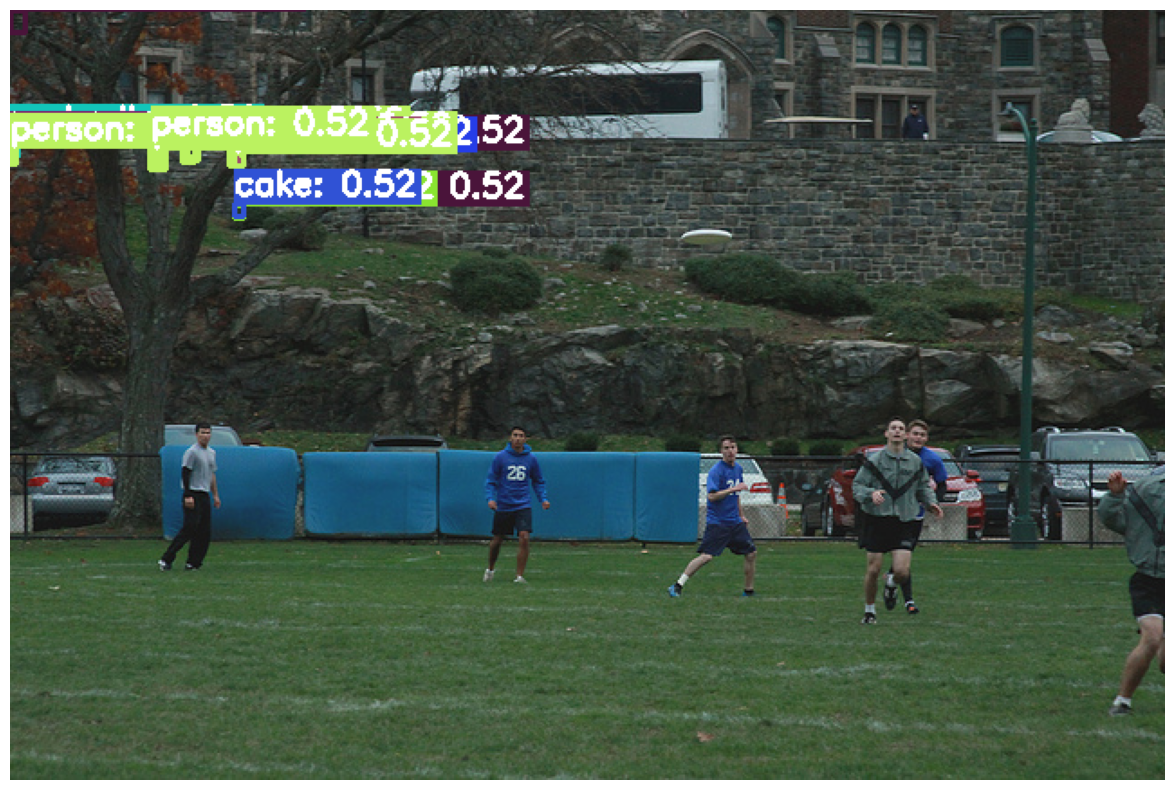

In [45]:
# --- Pipeline d'Inférence Complet ---

# 1. Charger le modèle entraîné
inference_model = CenterNet(num_classes=NUM_CLASSES).to(DEVICE)
MODEL_SAVE_PATH = "/kaggle/working/best_centernet_model.pth"
try:
    inference_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
    print(f"Poids du modèle chargés depuis '{MODEL_SAVE_PATH}'.")
except FileNotFoundError:
    print(f"ERREUR : Fichier de modèle '{MODEL_SAVE_PATH}' non trouvé. Assurez-vous d'avoir terminé l'entraînement.")
    # Si le fichier n'existe pas, on arrête ici
    inference_model = None

if inference_model:
    # **IMPORTANT** : Mettre le modèle en mode évaluation
    inference_model.eval()

    # 2. Sélectionner une image de test aléatoire dans le set de validation
    val_dataset = COCOCenterNetDataset(split='val')
    img_id = random.choice(val_dataset.image_ids)
    img_info = val_dataset.coco.loadImgs(img_id)[0]
    img_path = os.path.join(VAL_IMG_DIR, img_info['file_name'])

    # 3. Charger et pré-traiter l'image
    # Garder une copie de l'image originale pour la visualisation finale
    original_image = cv2.imread(img_path)
    
    # Le pré-traitement DOIT être identique à celui de l'entraînement
    image_for_model = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    image_for_model = cv2.resize(image_for_model, (INPUT_W, INPUT_H))
    image_tensor = torch.from_numpy(image_for_model.astype(np.float32) / 255.0).permute(2, 0, 1)
    image_tensor = image_tensor.unsqueeze(0).to(DEVICE) # Ajouter la dimension du batch

    # 4. Faire l'inférence
    with torch.no_grad():
        outputs = inference_model(image_tensor)

    # 5. Décoder les sorties
    detections = decode_centernet_output(
        heatmap=outputs['heatmap'],
        size=outputs['size'],
        offset=outputs['offset'],
        conf_thresh=0.3 # On peut jouer avec ce seuil
    )

    # 6. Dessiner les détections sur l'image originale
    # On redimensionne l'image du modèle à la taille originale pour dessiner les boîtes correctement
    output_image = draw_detections(original_image, detections)
    
    # 7. Afficher le résultat
    print(f"Affichage des résultats pour l'image : {img_info['file_name']}")
    print(f"Nombre d'objets détectés : {len(detections)}")
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()